In [1]:
import numpy as np
from numpy import random
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import math
import sys 
import shutil
from sklearn.metrics import mean_squared_error
from datetime import datetime
from pandas import read_csv
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
from pandas import DataFrame
from pandas import DataFrame
import sktime
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from scipy.signal import find_peaks

In [2]:
#Data location
pathON="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/ON_data/"
pathOFF="C:/Users/pierr/Documents_kanop/Shps/Pierre_points_for_louis/Bureau/interpo_ONOFF/Luigino/OFF_data/"

In [3]:
#Storing in a list the adresses of all the data files in the notebook

data_files_ON=[]
file_names_ON=[]

data_files_OFF=[]
file_names_OFF=[]
data_files_ALL=[]
file_names_ALL=[]

#Storing in a list the adresses of all the data files in the notebook
for filename in os.listdir(pathOFF):
    f = os.path.join(pathOFF,filename)
    if os.path.isfile(f):
        data_files_OFF.append(f)
        file_names_OFF.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)
for filename in os.listdir(pathON):
    f = os.path.join(pathON,filename)
    if os.path.isfile(f):
        data_files_ON.append(f)
        file_names_ON.append(filename)
        data_files_ALL.append(f)
        file_names_ALL.append(filename)     

In [4]:
# Using data_files with only the 36 binning
Filter=True
binning=37


if Filter==True:
    
    idx_OFF=[]
    idx_ON=[]
    dataON=[]
    dataOFF=[]
    for i in range(len(data_files_OFF)):
        dataframe = pd.read_csv(data_files_OFF[i])
        lg = len(dataframe)
        
        if lg==binning:
            idx_OFF.append(i)
    
    for i in range(len(data_files_ON)):
        dataframe = pd.read_csv(data_files_ON[i])
        lg = len(dataframe)
        if lg==binning:
            idx_ON.append(i)


    for i in range(len(idx_OFF)):

        a=idx_OFF[i]
        dataOFF.append(data_files_OFF[a])
    for i in range(len(idx_ON)):

        a=idx_ON[i]
        dataON.append(data_files_ON[a])

idx = idx_OFF+idx_ON


In [5]:
#Function to obtain my custom features

import warnings
warnings.filterwarnings("ignore")

def peak_study(array,time,delta_array):
    
    indices = find_peaks(array)
    indices=np.delete(indices,-1)
    y=[array[j] for j in indices]
    x=[time[j] for j in indices]
    y_err=[delta_array[j] for j in indices]
    
    x=np.hstack(x)
    y=np.hstack(y)
    y_err=np.hstack(y_err)
    
    copy_flux=y.copy()
    copy_time=x.copy()
    a=np.argmax(copy_flux)
    ymax1=copy_flux[a]
    tmax1=time[a]
    
    copy_time=np.delete(copy_time,a)
    copy_flux=np.delete(copy_flux,a)
    a=np.argmax(copy_flux)
    ymax2=copy_flux[a]
    tmax2=copy_time[a]
    
    one_to_second_flux=abs(ymax1-ymax2)
    one_to_second_time=abs(tmax1-tmax2)

    
    min_max_peak= abs(max(y)-min(y))
    arr=[1,-1]
    for i in range(len(y)):
        if np.isnan(y[i])==False:
            error=y_err[i]
            choice=np.random.choice(arr,1)
            if choice ==1:
                y[i]=y[i]+error
            if choice==-1:
                y[i]=y[i]-error
                
    peak_magnitudes=y
    nb_peaks=len(y)
    delta_energy_arr=[]
    delta_time_arr=[]
    
    for i in range(nb_peaks-1):
        
        delta = x[i+1]-x[i]
        delta_energy=abs(y[i+1]-y[i])
        delta_time_arr.append(delta)
        delta_energy_arr.append(delta_energy)

        
    NG_diff_mean_peaks=np.mean(delta_energy_arr)
    max_diff_mean_peaks=max(y)-np.mean(y)
    min_diff_mean_peaks=min(y)-np.mean(y)
    peaks_time_delay=np.mean(delta_time_arr)
    std_peaks=np.std(y)
    mean_peaks=np.mean(y)
    var_peaks=np.var(y)
    mean_arr=np.mean(array)
    maxi=max(array)
    mini=min(array)
    amplitude=max(array)-min(array)
    std=np.std(array)
    return nb_peaks,peak_magnitudes,peaks_time_delay,std_peaks,mean_peaks,NG_diff_mean_peaks,max_diff_mean_peaks,min_diff_mean_peaks,mean_arr,maxi,mini,amplitude,std,one_to_second_flux,one_to_second_time,min_max_peak


In [6]:
#Machine learning section and testing

In [7]:
#Calculating features and putting them in arrays for each class

lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF

Labels=[]



nb_peaks_arr_flux =[]
peak_magnitudes_arr_flux =[]
peaks_time_delay_arr_flux =[]
std_peaks_arr_flux =[]
mean_peaks_arr_flux =[]

NG_diff_mean_peaks_arr_flux =[]
max_diff_mean_peaks_arr_flux =[]
min_diff_mean_peaks_arr_flux =[]
mean_arr_flux=[]
max_arr_flux=[]
min_arr_flux=[]
amplitude_flux=[]
std_flux=[]
one_two_flux=[]
one_two_time=[]
min_max=[]
for i in range(len(dataOFF)):
    
    dataframe=pd.read_csv(dataOFF[i],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    
    mjd=np.array(dataframe['MJD'])
    flux=np.array(dataframe['Flux'])
    photon_idx=np.array(dataframe['Photon Index'])
    delta_index=np.array(dataframe['Delta Index'])
    delta_flux=np.array(dataframe['Delta Flux'])
    

    nb_peaks,peak_magnitudes,peaks_time_delay,std_peaks,mean_peaks,NG_diff_mean_peaks,max_diff_mean_peaks,min_diff_mean_peaks,mean_arr,maxi,mini,amplitude,std,one_to_second_flux,one_to_second_time,min_max_peak=peak_study(flux,mjd,delta_flux)
                                                                                                                                           
    nb_peaks_arr_flux.append(nb_peaks)
    peak_magnitudes_arr_flux.append(peak_magnitudes)
    peaks_time_delay_arr_flux.append(peaks_time_delay)
    std_peaks_arr_flux.append(std_peaks)
    mean_peaks_arr_flux.append(mean_peaks)

    NG_diff_mean_peaks_arr_flux.append(NG_diff_mean_peaks)
    max_diff_mean_peaks_arr_flux.append(max_diff_mean_peaks)
    min_diff_mean_peaks_arr_flux.append(min_diff_mean_peaks)
    
    mean_arr_flux.append(mean_arr)
    max_arr_flux.append(maxi)
    min_arr_flux.append(mini)
    amplitude_flux.append(amplitude)
    std_flux.append(std)
    one_two_flux.append(one_to_second_flux)
    one_two_time.append(one_to_second_time)
    min_max.append(min_max_peak)
for i in range(len(dataON)):
    
    dataframe=pd.read_csv(dataON[i],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    
    mjd=np.array(dataframe['MJD'])
    flux=np.array(dataframe['Flux'])
    photon_idx=np.array(dataframe['Photon Index'])
    delta_index=np.array(dataframe['Delta Index'])
    delta_flux=np.array(dataframe['Delta Flux'])

    nb_peaks,peak_magnitudes,peaks_time_delay,std_peaks,mean_peaks,NG_diff_mean_peaks,max_diff_mean_peaks,min_diff_mean_peaks,mean_arr,maxi,mini,amplitude,std,one_to_second_flux,one_to_second_time,min_max_peak=peak_study(flux,mjd,delta_flux)
    nb_peaks_arr_flux.append(nb_peaks)
    peak_magnitudes_arr_flux.append(peak_magnitudes)
    peaks_time_delay_arr_flux.append(peaks_time_delay)
    std_peaks_arr_flux.append(std_peaks)
    mean_peaks_arr_flux.append(mean_peaks)

    NG_diff_mean_peaks_arr_flux.append(NG_diff_mean_peaks)
    max_diff_mean_peaks_arr_flux.append(max_diff_mean_peaks)
    min_diff_mean_peaks_arr_flux.append(min_diff_mean_peaks)
    
    mean_arr_flux.append(mean_arr)
    max_arr_flux.append(maxi)
    min_arr_flux.append(mini)
    amplitude_flux.append(amplitude)
    std_flux.append(std)
    one_two_flux.append(one_to_second_flux)
    one_two_time.append(one_to_second_time)
    min_max.append(min_max_peak)
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))

In [40]:
nbfeatures=1

data_matrix=np.zeros((nbfeatures,lg))


#Best combination of  features for best performance of classification
# data_matrix[0]=nb_peaks_arr_flux 0.17
# data_matrix[0]=peaks_time_delay_arr_flux 0.23
# data_matrix[0]=std_peaks_arr_flux 0.0


#Other features created by peak study function 

# data_matrix[0]=mean_peaks_arr_flux 0.0
# data_matrix[0]=min_max 0.0
# data_matrix[0]=std_flux 0.0
# data_matrix[0]=amplitude_flux 0.125
# data_matrix[0]=mean_arr_flux 0.0
# data_matrix[0]=min_arr_flux 0.0
# data_matrix[0]=one_two_flux 0.0
data_matrix[0]=one_two_time 0.206

# data_matrix[0]=NG_diff_mean_peaks_arr_flux
# data_matrix[12]=max_diff_mean_peaks_arr_flux
# data_matrix[13]=min_diff_mean_peaks_arr_flux






data_matrix=data_matrix.reshape((lg,nbfeatures))

In [60]:
nbfeatures=3

data_matrix=np.zeros((nbfeatures,lg))

data_matrix[0]=nb_peaks_arr_flux 
data_matrix[1]=peaks_time_delay_arr_flux 
# data_matrix[1]=amplitude_flux 
data_matrix[2]=one_two_time 

data_matrix=data_matrix.reshape((lg,nbfeatures))

In [61]:
import cesium
from cesium import featurize

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []
bad_ON=[]
iterations=10
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

for i in  range(iterations):
                 
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.1, random_state=i)


    model = RandomForestClassifier(n_estimators=2000, max_features="auto",
                                          random_state=i,class_weight =class_weight)
    Labels=np.hstack(Labels)
    model.fit(x_train, y_train)
    prediction= model.predict(x_test)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0

    for i in range(len(y_test)):
        if y_test[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
                
            else : 
                fon+=1
                bad_ON.append(i)
        if y_test[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(prediction,y_test)
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))

Accuracy for ON class:  14.71062271062271 %
Accuracy for OFF class:  96.11134866288253 %
False Positive rate:  85.28937728937728 %
False Negative rate:  3.888651337117473 %
F1 score:  0.19919831630357945


In [10]:
import cesium
from cesium import featurize

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []
bad_ON=[]
iterations=100
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

for i in  range(iterations):
                 
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.1, random_state=i)


    model = KNeighborsClassifier(2,weights='distance')
    Labels=np.hstack(Labels)
    model.fit(x_train, y_train)
    prediction= model.predict(x_test)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0

    for i in range(len(y_test)):
        if y_test[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
                
            else : 
                fon+=1
                bad_ON.append(i)
        if y_test[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(prediction,y_test,average='weighted')
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))

Accuracy for ON class:  32.30058348514231 %
Accuracy for OFF class:  93.03384024428124 %
False Positive rate:  67.69941651485769 %
False Negative rate:  6.966159755718788 %
F1 score:  0.8675313827056944


In [11]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification



ON_accuracy=[]
OFF_accuracy=[]
fscore=[]
FPOS=[]
FNEG= []
bad_ON=[]
iterations=100
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF
weight_for_0 = (1 / lgOFF) * (lg / 2.0)
weight_for_1 = (1 / lgON) * (lg / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

for i in range(iterations):
                 
    x_train, x_test, y_train, y_test = train_test_split(data_matrix, Labels, test_size=0.1, random_state=i)


    
    model = AdaBoostClassifier(n_estimators=500, random_state=0)
    model.fit(x_train, y_train)
    Labels=np.hstack(Labels)
    prediction= model.predict(x_test)
    on_score=0
    on_nbs=0
    off_nbs=0
    off_score=0
    foff=0
    fon=0

    for i in range(len(y_test)):
        if y_test[i]==1 :
            on_nbs+=1
            if prediction[i]==1:
                on_score+=1
                
            else : 
                fon+=1
                bad_ON.append(i)
        if y_test[i]==0 :
            off_nbs+=1
            if prediction[i]==0:
                off_score+=1 
            else:
                foff+=1
    if on_nbs>0:    
        ON_accuracy.append(100*(on_score/on_nbs))
        FPOS.append(100*(fon/on_nbs))
    OFF_accuracy.append(100*(off_score/off_nbs))
    FNEG.append(100*(foff/off_nbs))
    f1= f1_score(prediction,y_test)
    fscore.append(f1)
print("Accuracy for ON class: ",np.mean(ON_accuracy) ,"%")
print("Accuracy for OFF class: ",np.mean(OFF_accuracy) ,"%")
print("False Positive rate: ",np.mean(FPOS) ,"%")
print("False Negative rate: ",np.mean(FNEG) ,"%")
print("F1 score: ",np.mean(fscore))

Accuracy for ON class:  0.28569753260155734 %
Accuracy for OFF class:  99.553270378694 %
False Positive rate:  99.71430246739845 %
False Negative rate:  0.4467296213060014 %
F1 score:  0.0050174348915767684


Mean standard deviation of peak magnitudes for OFF class:  2.8951383402421467e-08
Mean number of peaks in lightsource curve for OFF class:  10.691248770894788
Mean time difference between peaks for OFF class:  445.2715829254412
  


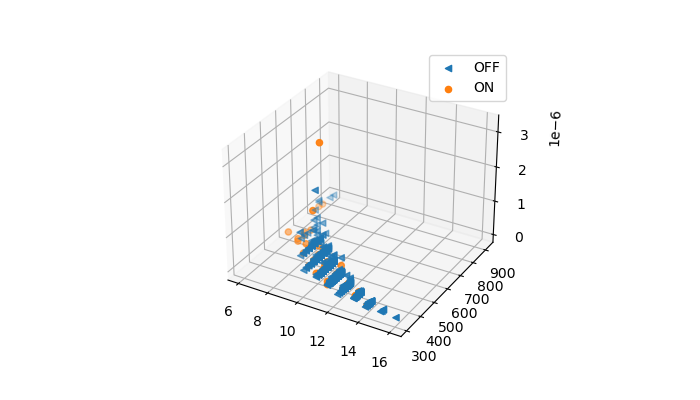

Mean standard deviation of peak magnitudes for ON class:  7.301842949965106e-08
Mean number of peaks in lightsource curve for ON class:  10.528455284552846
Mean time difference between peaks for ON class:  448.24899270942365


In [6]:
#Obtaining  mean values of features for each class
%matplotlib widget
from mpl_toolkits import mplot3d
 
lgON=len(dataON)
lgOFF=len(dataOFF)
lg=lgON+lgOFF

Labels=[]



nb_peaks_arr_flux =[]
peak_magnitudes_arr_flux =[]
peaks_time_delay_arr_flux =[]
std_peaks_arr_flux =[]
mean_peaks_arr_flux =[]

NG_diff_mean_peaks_arr_flux =[]
max_diff_mean_peaks_arr_flux =[]
min_diff_mean_peaks_arr_flux =[]
mean_arr_flux=[]
max_arr_flux=[]
min_arr_flux=[]
amplitude_flux=[]
std_flux=[]
one_two_flux=[]
one_two_time=[]
min_max=[]
for i in range(len(dataOFF)):
    
    dataframe=pd.read_csv(dataOFF[i],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    
    mjd=np.array(dataframe['MJD'])
    flux=np.array(dataframe['Flux'])
    photon_idx=np.array(dataframe['Photon Index'])
    delta_index=np.array(dataframe['Delta Index'])
    delta_flux=np.array(dataframe['Delta Flux'])
    

    nb_peaks,peak_magnitudes,peaks_time_delay,std_peaks,mean_peaks,NG_diff_mean_peaks,max_diff_mean_peaks,min_diff_mean_peaks,mean_arr,maxi,mini,amplitude,std,one_to_second_flux,one_to_second_time,min_max_peak=peak_study(flux,mjd,delta_flux)
                                                                                                                                           
    nb_peaks_arr_flux.append(nb_peaks)
    peak_magnitudes_arr_flux.append(peak_magnitudes)
    peaks_time_delay_arr_flux.append(peaks_time_delay)
    std_peaks_arr_flux.append(std_peaks)
    mean_peaks_arr_flux.append(mean_peaks)

    NG_diff_mean_peaks_arr_flux.append(NG_diff_mean_peaks)
    max_diff_mean_peaks_arr_flux.append(max_diff_mean_peaks)
    min_diff_mean_peaks_arr_flux.append(min_diff_mean_peaks)
    
    mean_arr_flux.append(mean_arr)
    max_arr_flux.append(maxi)
    min_arr_flux.append(mini)
    amplitude_flux.append(amplitude)
    std_flux.append(std)
    one_two_flux.append(one_to_second_flux)
    one_two_time.append(one_to_second_time)
    min_max.append(min_max_peak)
    
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))


z=std_peaks_arr_flux
x=nb_peaks_arr_flux
y=peaks_time_delay_arr_flux
fig = plt.figure(figsize = (7, 4))
ax = plt.axes(projection ="3d")
 
# Create Plot

ax.scatter3D(x, y, z, marker='<', s=20, label='OFF')

# plt.show()    

print("Mean standard deviation of peak magnitudes for OFF class: ",np.mean(std_peaks_arr_flux))
print("Mean number of peaks in lightsource curve for OFF class: ",np.mean(nb_peaks_arr_flux))
print("Mean time difference between peaks for OFF class: ",np.mean(peaks_time_delay_arr_flux))
print("  ")


Labels=[]
nb_peaks_arr_flux =[]
peak_magnitudes_arr_flux =[]
peaks_time_delay_arr_flux =[]
std_peaks_arr_flux =[]
mean_peaks_arr_flux =[]

NG_diff_mean_peaks_arr_flux =[]
max_diff_mean_peaks_arr_flux =[]
min_diff_mean_peaks_arr_flux =[]
mean_arr_flux=[]
max_arr_flux=[]
min_arr_flux=[]
amplitude_flux=[]
std_flux=[]
one_two_flux=[]
one_two_time=[]
min_max=[]
for i in range(len(dataON)):
    
    dataframe=pd.read_csv(dataON[i],index_col=[0])
    dataframe.columns=['MJD','Flux','Delta Flux','Photon Index','Delta Index','TS','fratio']
    
    mjd=np.array(dataframe['MJD'])
    flux=np.array(dataframe['Flux'])
    photon_idx=np.array(dataframe['Photon Index'])
    delta_index=np.array(dataframe['Delta Index'])
    delta_flux=np.array(dataframe['Delta Flux'])

    nb_peaks,peak_magnitudes,peaks_time_delay,std_peaks,mean_peaks,NG_diff_mean_peaks,max_diff_mean_peaks,min_diff_mean_peaks,mean_arr,maxi,mini,amplitude,std,one_to_second_flux,one_to_second_time,min_max_peak=peak_study(flux,mjd,delta_flux)
    nb_peaks_arr_flux.append(nb_peaks)
    peak_magnitudes_arr_flux.append(peak_magnitudes)
    peaks_time_delay_arr_flux.append(peaks_time_delay)
    std_peaks_arr_flux.append(std_peaks)
    mean_peaks_arr_flux.append(mean_peaks)

    NG_diff_mean_peaks_arr_flux.append(NG_diff_mean_peaks)
    max_diff_mean_peaks_arr_flux.append(max_diff_mean_peaks)
    min_diff_mean_peaks_arr_flux.append(min_diff_mean_peaks)
    
    mean_arr_flux.append(mean_arr)
    max_arr_flux.append(maxi)
    min_arr_flux.append(mini)
    amplitude_flux.append(amplitude)
    std_flux.append(std)
    one_two_flux.append(one_to_second_flux)
    one_two_time.append(one_to_second_time)
    min_max.append(min_max_peak)
    
#Creating labels
for i in range(lgOFF):
    
    Labels.append(int(0))
    
for i in range(lgON):
    Labels.append(int(1))
    
# fig = plt.figure()
# ax = plt.axes(projection="3d")

z=std_peaks_arr_flux
x=nb_peaks_arr_flux
y=peaks_time_delay_arr_flux

ax.scatter3D(x, y, z, marker='o', s=20, label='ON' );

# Add legend

ax.legend(loc=1)
 
# Show plot

plt.show()
    
print("Mean standard deviation of peak magnitudes for ON class: ",np.mean(std_peaks_arr_flux))
print("Mean number of peaks in lightsource curve for ON class: ",np.mean(nb_peaks_arr_flux))
print("Mean time difference between peaks for ON class: ",np.mean(peaks_time_delay_arr_flux))